In [ ]:
  # Install necessary libraries
  !pip install transformers
  !pip install torch

  # Import required libraries
  import pandas as pd
  import torch
  from transformers import BertTokenizer, BertForSequenceClassification
  from torch.utils.data import TensorDataset, DataLoader, RandomSampler
  from tqdm.notebook import tqdm


In [ ]:
import pandas as pd

# Assuming df is your DataFrame with the 'party' column
# If you haven't already loaded your DataFrame, load it first

# Display all unique values in the 'party' column
unique_parties = df['party'].unique()
print("Unique Parties:")
for party in unique_parties:
    print(party)

Unique Parties:
BJP
CONGRESS
AAP
TMC
SP


In [ ]:
import matplotlib.pyplot as plt
# Load the dataset
df = pd.read_csv('final_data.csv')

# Display the head of the DataFrame
print("Head of the DataFrame:")
print(df.head())

# Load multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize input texts
tokenized_texts = tokenizer(list(df['Tweet']), padding=True, truncation=True, return_tensors="pt")

# Convert string labels to numerical labels
label_map = {label: index for index, label in enumerate(df['party'].unique())}
df['label'] = df['party'].map(label_map)

# Prepare labels
labels = torch.tensor(df['label'])

Head of the DataFrame:
                                               Tweet party
0  PM Modi creates a new record of being the only...   BJP
1  @abhijitmajumder Appointment of Successor! \n\...   BJP
2  Which of the following should be top priority ...   BJP
3  After 5yrs of Modi ðŸ™\n\n-SC vs SC\n-EC vs E...   BJP
4  @RenukaJain6\nI still remember your video mass...   BJP


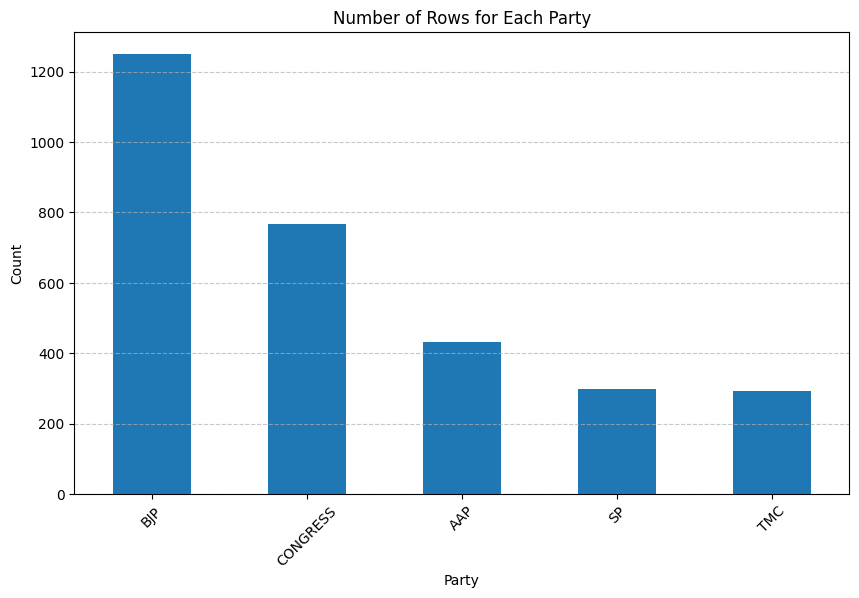

In [ ]:
# Count the number of rows for each party
party_counts = df['party'].value_counts()

# Plotting the histogram
plt.figure(figsize=(10, 6))
party_counts.plot(kind='bar')
plt.title('Number of Rows for Each Party')
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Create TensorDataset
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)

# Define batch size
batch_size = 8

# Create DataLoader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

# Splitting the dataset into train and validation sets
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:

# Tokenize and prepare validation dataset
validation_tokenized_texts = tokenizer(list(validation_df['Tweet']), padding=True, truncation=True, return_tensors="pt")
validation_labels = torch.tensor(validation_df['label'].tolist())  # Convert Series to list
validation_dataset = TensorDataset(validation_tokenized_texts['input_ids'], validation_tokenized_texts['attention_mask'], validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

# Load pre-trained multilingual BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(df['party'].unique()))

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training parameters
predicted_labels_list = []
epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Get the device
model.to(device)  # Move the model to the device

# Lists to store training loss and accuracy
train_loss_values = []
train_accuracy_values = []

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training step
    for batch in tqdm(dataloader, desc="Iteration"):
        batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        # Compute training loss
        epoch_loss += loss.item()

        # Compute training accuracy
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[2].size(0)
        predicted_labels_list.extend(predicted_labels.tolist())  # Extend the list with predicted labels
    # Calculate average epoch loss and accuracy
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_loss_values.append(avg_epoch_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracy_values.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}')
print(predicted_labels_list)


Epoch 1/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.2199, Accuracy: 0.9168
Epoch 2/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.1651, Accuracy: 0.9303
Epoch 3/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.1436, Accuracy: 0.9273
Epoch 4/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.1208, Accuracy: 0.9398
[4, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 2, 3, 0, 2, 0, 3, 3, 2, 1, 2, 2, 0, 0, 1, 4, 4, 0, 1, 4, 4, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 4, 0, 2, 0, 3, 0, 1, 0, 1, 4, 2, 0, 1, 3, 1, 0, 3, 2, 2, 0, 4, 1, 1, 0, 0, 1, 0, 4, 1, 1, 1, 0, 1, 0, 0, 0, 0, 4, 0, 3, 3, 3, 0, 4, 4, 1, 4, 2, 2, 1, 0, 2, 0, 3, 0, 4, 1, 0, 4, 0, 1, 0, 1, 1, 0, 3, 1, 3, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 1, 0, 2, 0, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 0, 0, 0, 3, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 4, 0, 2, 1, 0, 0, 1, 0, 0, 4, 1, 1, 2, 2, 3, 2, 0, 1, 4, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 1, 4, 3, 2, 0, 0, 1, 0, 0, 1, 1, 2, 1, 4, 3, 1, 2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 2, 3, 0, 0, 2, 1, 4, 3, 0, 3, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 4, 4, 0, 2, 0, 1, 4, 4, 0, 2, 1, 2, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 2, 3, 1, 1, 3, 4, 0, 4, 2, 0, 0, 1, 1, 0, 1, 3, 1, 3, 1, 1, 3, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 4, 0, 0, 4, 0, 0, 2, 0, 2, 4, 1, 

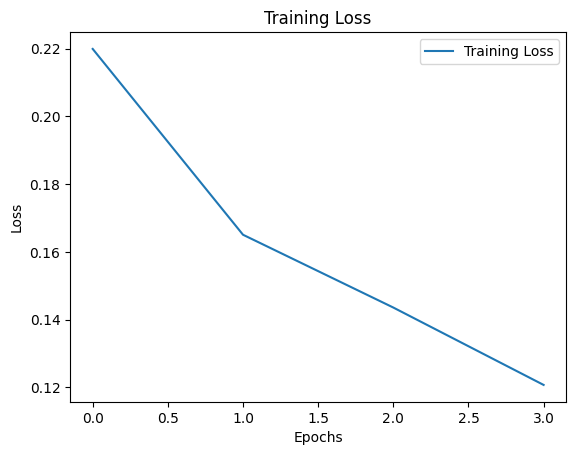

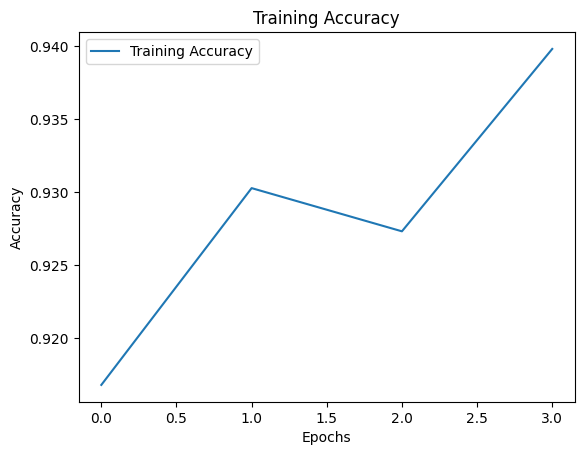

Validation:   0%|          | 0/77 [00:00<?, ?it/s]

Validation Loss: 0.1177, Validation Accuracy: 0.9392


In [ ]:
# Plotting the training loss
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Validation
model.eval()
validation_loss = 0.0
correct_val_predictions = 0
total_val_predictions = 0

for batch in tqdm(validation_dataloader, desc="Validation"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        validation_loss += loss.item()
        _, predicted_labels = torch.max(logits, 1)
        correct_val_predictions += (predicted_labels == batch[2]).sum().item()
        total_val_predictions += batch[2].size(0)

# Calculate validation loss and accuracy
avg_val_loss = validation_loss / len(validation_dataloader)
val_accuracy = correct_val_predictions / total_val_predictions

print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
# Sample tweet
sample_tweet = "modi is best pm"

# Tokenize the sample tweet
sample_tokenized_text = tokenizer.encode_plus(sample_tweet, padding=True, truncation=True, return_tensors="pt")

# Move input tensors to the device
sample_tokenized_text = {key: val.to(device) for key, val in sample_tokenized_text.items()}

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(**sample_tokenized_text)
    logits = outputs.logits

# Predicted label
_, predicted_label_idx = torch.max(logits, 1)
predicted_label = list(label_map.keys())[list(label_map.values()).index(predicted_label_idx.item())]

print("Sample Tweet:", sample_tweet)
print("Predicted Party:", predicted_label)


Sample Tweet: modi is best pm
Predicted Party: BJP


In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr




Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
import pytesseract
from PIL import Image
from google.colab import files
import cv2

# Upload image
uploaded = files.upload()

# Process uploaded image
for filename in uploaded.keys():
    # Read uploaded image
    img = cv2.imread(filename)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding to binarize the image
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Invert the binary image
    inverted_thresh = cv2.bitwise_not(thresh)

    # Perform OCR on the preprocessed image
    extracted_text = pytesseract.image_to_string(inverted_thresh)

    # Tokenize the extracted text
    tokenized_text = tokenizer.encode_plus(extracted_text, padding=True, truncation=True, return_tensors="pt")

    # Move input tensors to the device
    tokenized_text = {key: val.to(device) for key, val in tokenized_text.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**tokenized_text)
        logits = outputs.logits

    # Predicted label
    _, predicted_label_idx = torch.max(logits, 1)
    predicted_label = list(label_map.keys())[list(label_map.values()).index(predicted_label_idx.item())]

    print("Extracted Text from Image:", extracted_text)
    print("Predicted Party:", predicted_label)


Saving 2.png to 2 (1).png
Extracted Text from Image: BREAKING

Delhi CM @ArvindKejriwai's Order from Jail to all AAP MLAs
Meet the Janta of your constituency daily.

Listen to their problems and ensure quick resolution to any issue
Entire Delhi is our Family, lets together solve all their issues,

Wife @kejriwalSunita reads out his message

Predicted Party: AAP


Naive Bayes Classifier Accuracy: 0.8111658456486043
SVM Classifier Accuracy: 0.8981937602627258


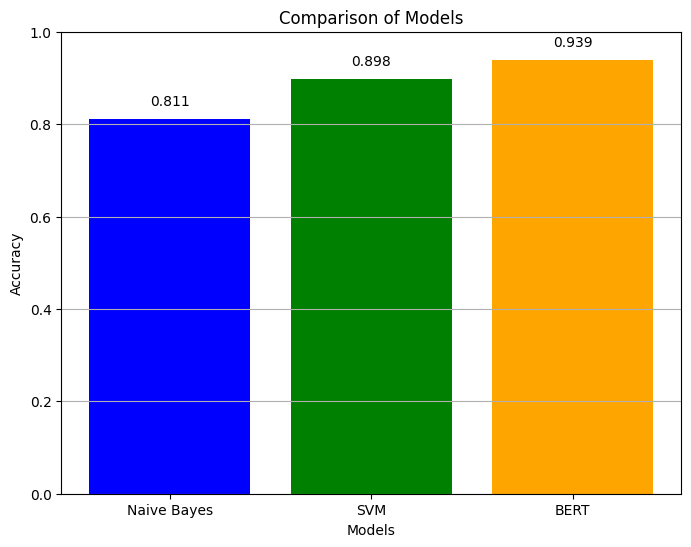

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Create CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(train_df['Tweet'])

# Transform the validation data
X_val = vectorizer.transform(validation_df['Tweet'])

# Initialize and train the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, train_df['label'])

# Predict using Naive Bayes on the validation set
naive_bayes_predictions = naive_bayes_classifier.predict(X_val)

# Calculate Naive Bayes accuracy
naive_bayes_accuracy = accuracy_score(validation_df['label'], naive_bayes_predictions)

print("Naive Bayes Classifier Accuracy:", naive_bayes_accuracy)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, train_df['label'])

# Predict using SVM on the validation set
svm_predictions = svm_classifier.predict(X_val)

# Calculate SVM accuracy
svm_accuracy = accuracy_score(validation_df['label'], svm_predictions)

print("SVM Classifier Accuracy:", svm_accuracy)

# Plot accuracy comparison
plt.figure(figsize=(8, 6))
models = ['Naive Bayes', 'SVM', 'BERT']
accuracies = [naive_bayes_accuracy, svm_accuracy, val_accuracy]
colors = ['blue', 'green', 'orange']
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Models')
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of the bars
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.03, f'{accuracies[i]:.3f}', ha='center', color='black')

plt.show()


In [ ]:
# Set model to evaluation mode
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix

model.eval()

# List to store predicted labels
predicted_labels_list = []

# Loop through validation dataloader for predictions
for batch in tqdm(validation_dataloader, desc="Predicting"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        predicted_labels_list.extend(predicted_labels.cpu().numpy().tolist())

# Calculate metrics for BERT
bert_recall = recall_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_f1 = f1_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_accuracy = accuracy_score(validation_df['label'], predicted_labels_list)

print("\nBERT Classifier Metrics:")
print(f"Recall: {bert_recall:.4f}")
print(f"F1 Score: {bert_f1:.4f}")
print(f"Accuracy: {bert_accuracy:.4f}")


Predicting:   0%|          | 0/77 [00:00<?, ?it/s]


BERT Classifier Metrics:
Recall: 0.9392
F1 Score: 0.9395
Accuracy: 0.9392


Naive Bayes Classifier Metrics:
Recall: 0.8112
F1 Score: 0.8023
Accuracy: 0.8112

SVM Classifier Metrics:
Recall: 0.8982
F1 Score: 0.8990
Accuracy: 0.8982

BERT Classifier Metrics:
Recall: 0.9392
F1 Score: 0.9395
Accuracy: 0.9392


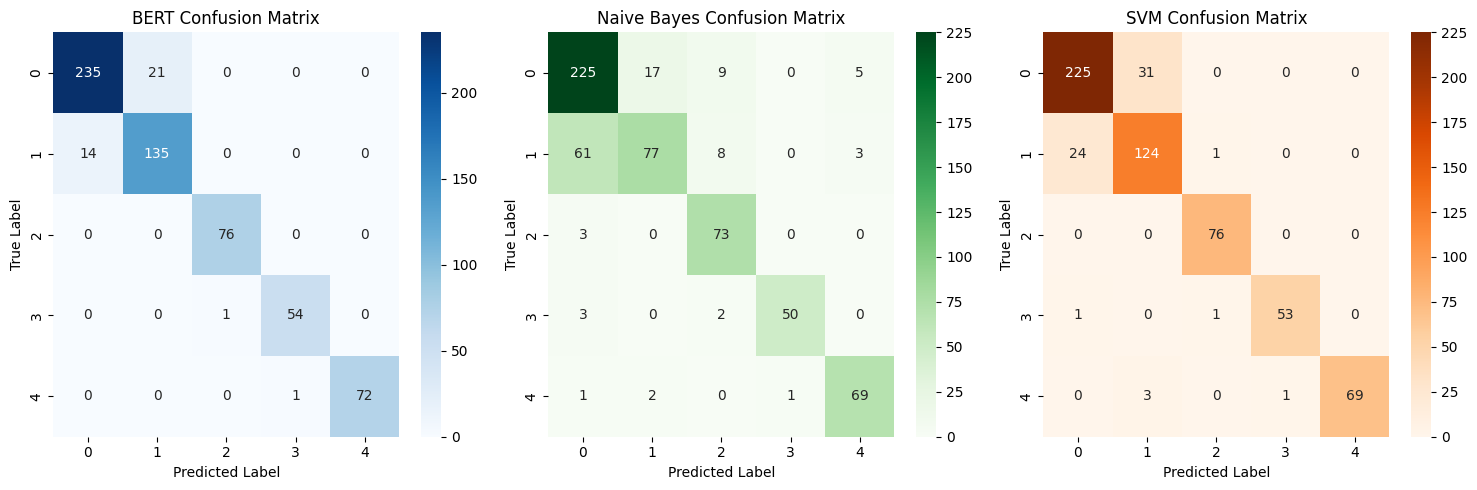

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score
import seaborn as sns

# Calculate metrics for Naive Bayes
naive_bayes_recall = recall_score(validation_df['label'], naive_bayes_predictions, average='weighted', zero_division=1)
naive_bayes_f1 = f1_score(validation_df['label'], naive_bayes_predictions, average='weighted', zero_division=1)
naive_bayes_accuracy = accuracy_score(validation_df['label'], naive_bayes_predictions)

print("Naive Bayes Classifier Metrics:")
print(f"Recall: {naive_bayes_recall:.4f}")
print(f"F1 Score: {naive_bayes_f1:.4f}")
print(f"Accuracy: {naive_bayes_accuracy:.4f}")

# Calculate metrics for SVM
svm_recall = recall_score(validation_df['label'], svm_predictions, average='weighted', zero_division=1)
svm_f1 = f1_score(validation_df['label'], svm_predictions, average='weighted', zero_division=1)
svm_accuracy = accuracy_score(validation_df['label'], svm_predictions)

print("\nSVM Classifier Metrics:")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")
print(f"Accuracy: {svm_accuracy:.4f}")

# Calculate metrics for BERT
bert_recall = recall_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_f1 = f1_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_accuracy = accuracy_score(validation_df['label'], predicted_labels_list)

print("\nBERT Classifier Metrics:")
print(f"Recall: {bert_recall:.4f}")
print(f"F1 Score: {bert_f1:.4f}")
print(f"Accuracy: {bert_accuracy:.4f}")

# Create confusion matrices
confusion_matrix_bert = confusion_matrix(validation_df['label'], predicted_labels_list)
confusion_matrix_naive_bayes = confusion_matrix(validation_df['label'], naive_bayes_predictions)
confusion_matrix_svm = confusion_matrix(validation_df['label'], svm_predictions)

# Plot heat maps for confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix_bert, annot=True, fmt="d", cmap="Blues")
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix_naive_bayes, annot=True, fmt="d", cmap="Greens")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix_svm, annot=True, fmt="d", cmap="Oranges")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()
